# Dataset Friuli-Venezia Giulia
Registrazione delle misure combinate di [ARPAFVG](https://www.osmer.fvg.it/home.php), ISAC e SCIA.

## Caricamento librerie e dichiarazione del dataset
Scrivere nel file `load_daily.R` una funzione `dataset_spec()` che fornisca in lista le informazioni sul dataset da caricare nel database.

In [1]:
dataset <- "ARPAFVG"
state <- "Friuli-Venezia Giulia"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

source(str_glue("notebooks/ds_regionali/FVG/procedures/load_daily.R"))
source("notebooks/ds_regionali/procedure/common_steps.R")
source("notebooks/ds_regionali/procedure/checkpoint.R")
source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/query/data.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")
add_ds_info(dataset, dataset_spec())


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



## Uniformazione dei dati
Produzione di un checkpoint da dati raw. Scrivere una funzione `load_daily_data.<dataset>(first_date, last_date)` nel file `load_daily.R` che restituisca un dizionario con elementi:
- `meta`: una tabella con (almeno) i campi da `dataset` a `state` compilati;
- `data`: una tabella Arrow già nel formato standard.

Le funzioni di `common_steps` si occupano di completare ed effettuare il checkpoint.


In [4]:
daily_dataset <- load_daily_data.arpafvg() |> prepare_daily_data(conns$stations)
save_checkpoint(daily_dataset$checkpoint, dataset, "raw", partitioning = "variable")
write_extra_metadata(daily_dataset$extra_meta |> collect(), dataset, conns$stations)
rm(daily_dataset)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2076698,111.0,4014138,214.4,NA,4014138,214.4
Vcells,3741793,28.6,8388608,64.0,16384,5066661,38.7


In [5]:
qc_checkpoint(dataset, conns$data)


## Controllo disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese e sul territorio a confronto con SCIA e ISAC.

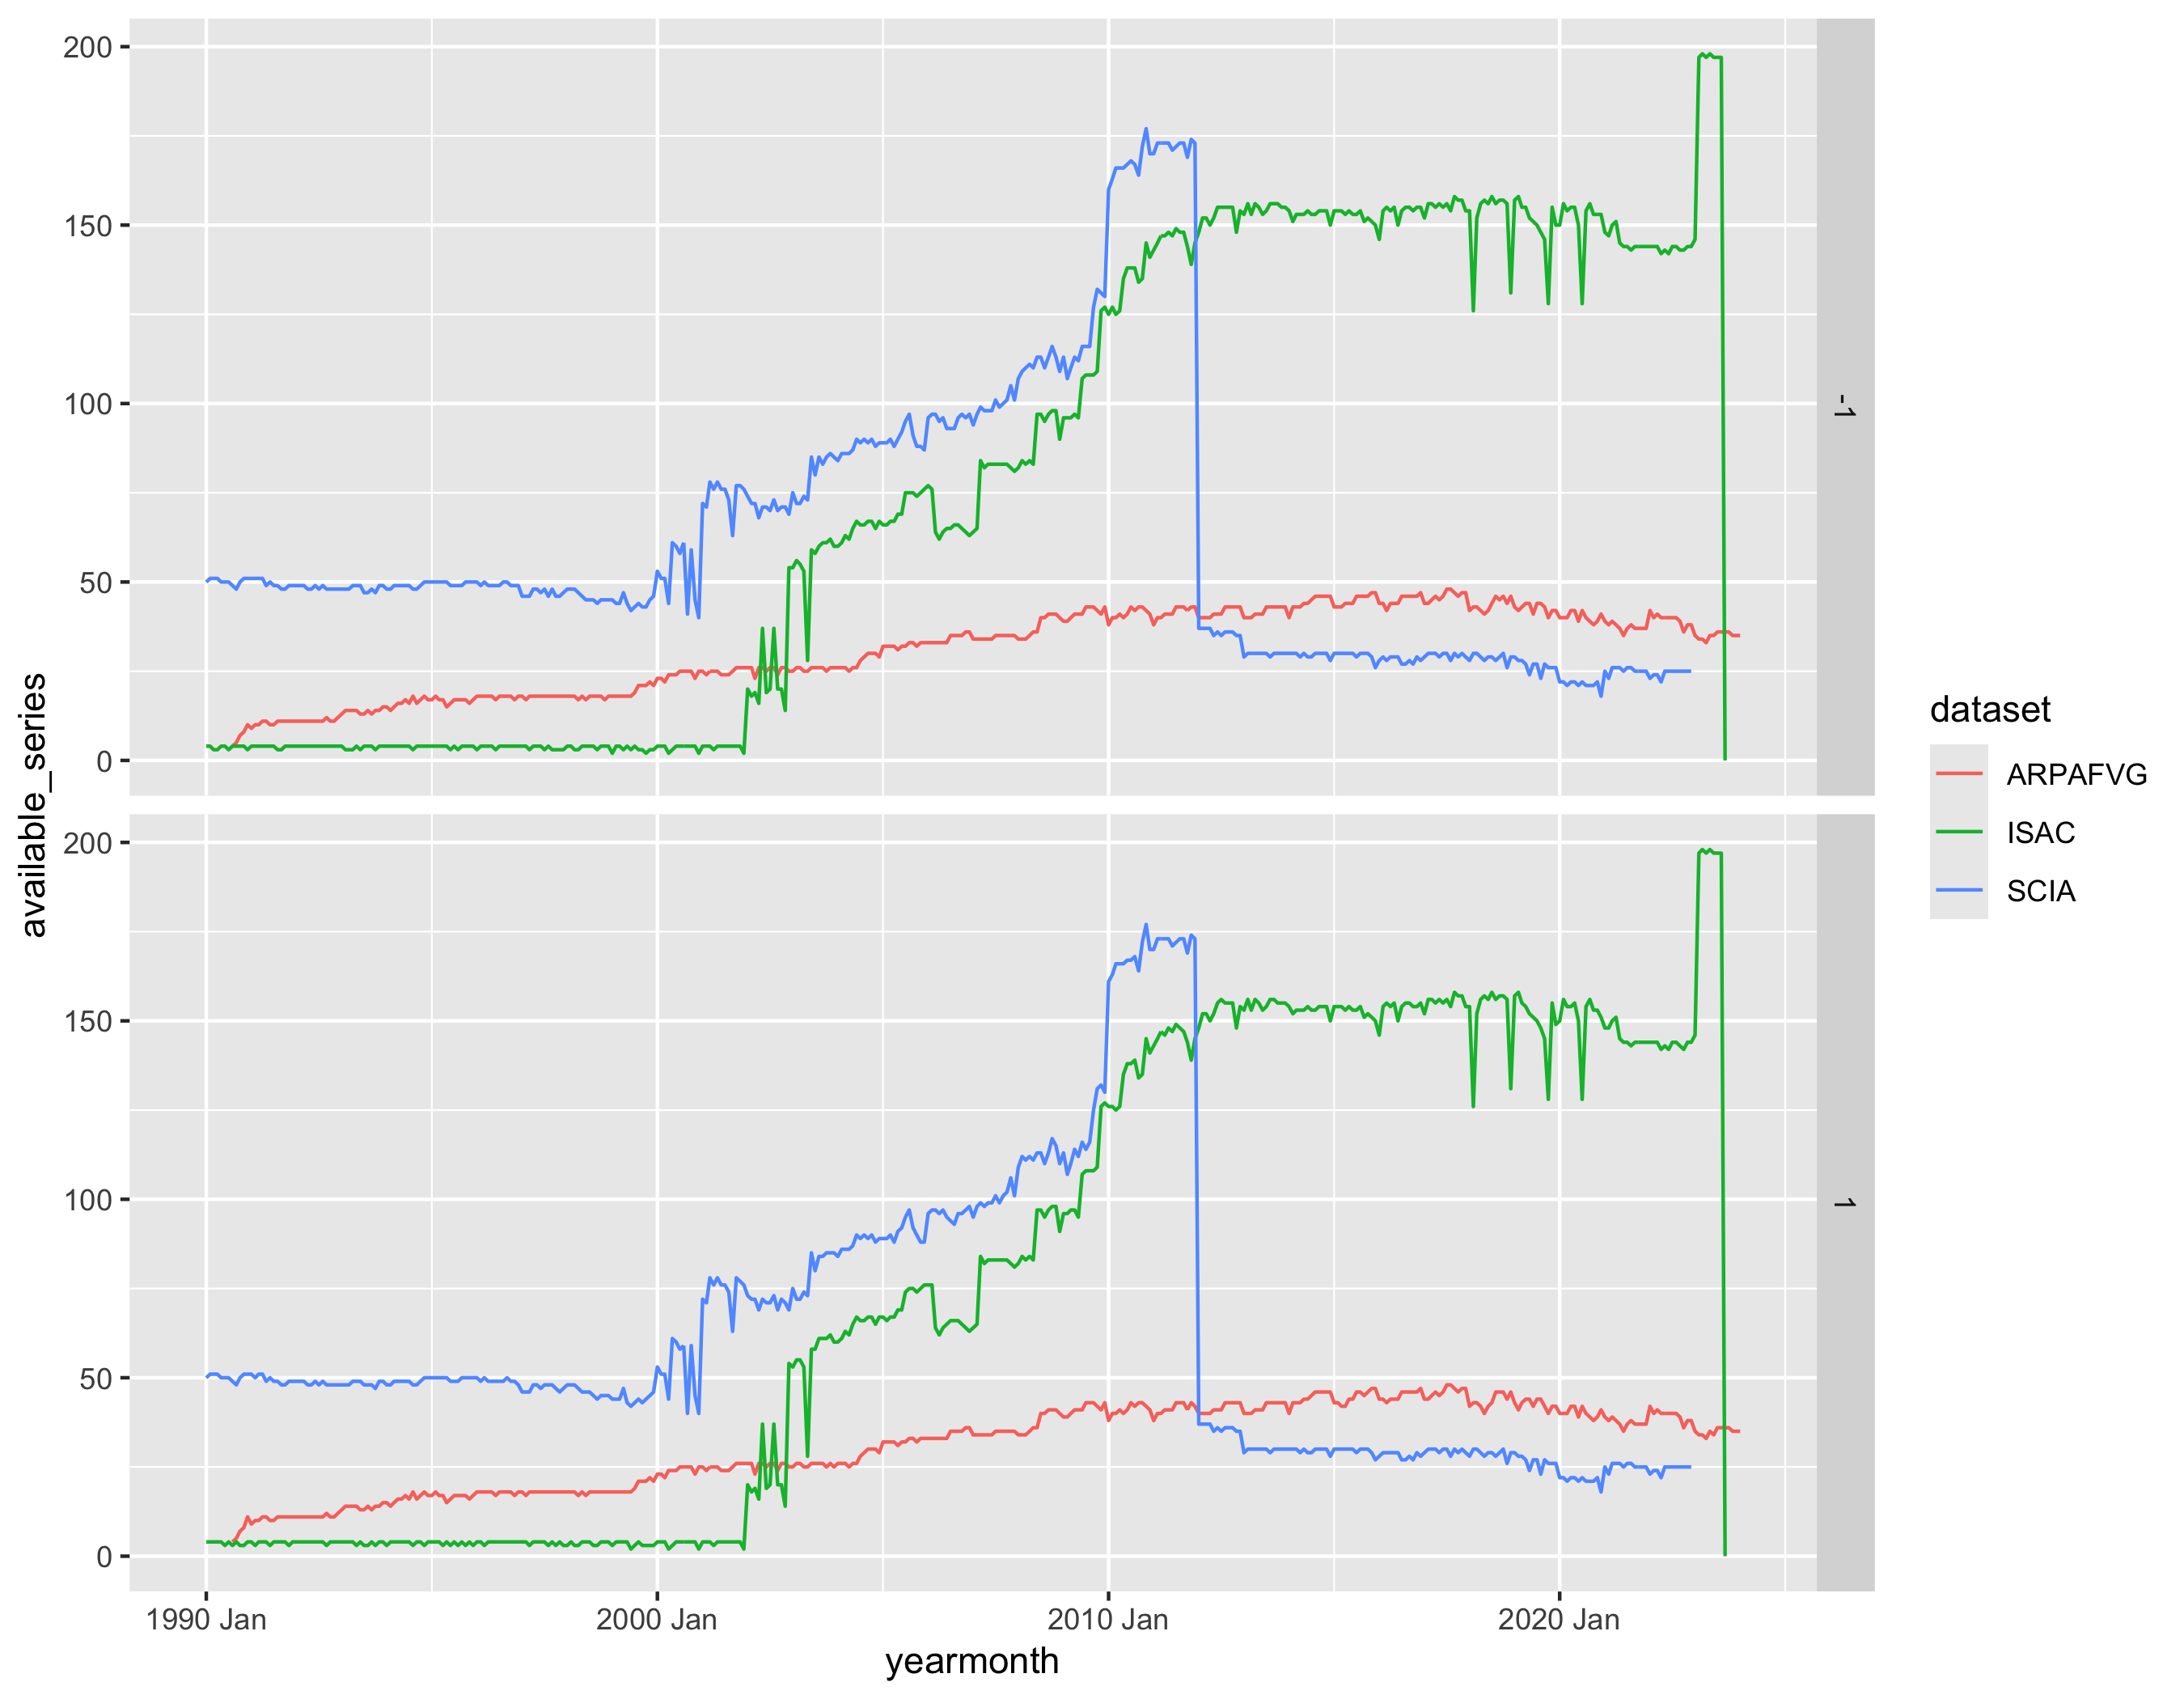

In [3]:
conn <- conns$data
stations <- query_checkpoint_meta(c(dataset, "SCIA", "ISAC"), "qc1", conn) |> filter(state == "Friuli-Venezia Giulia")
state_data <- query_checkpoint_data(c(dataset, "SCIA", "ISAC"), "qc1", conn, hive_types = list("valid" = "BOOLEAN", "variable" = "INT")) |>
    filter(date >= as.Date("1990-01-01"), valid) |>
    semi_join(stations, join_by(dataset, sensor_key))
pp <- ymonthly_availabilities(state_data)
pp$plot + facet_grid(variable ~ .)


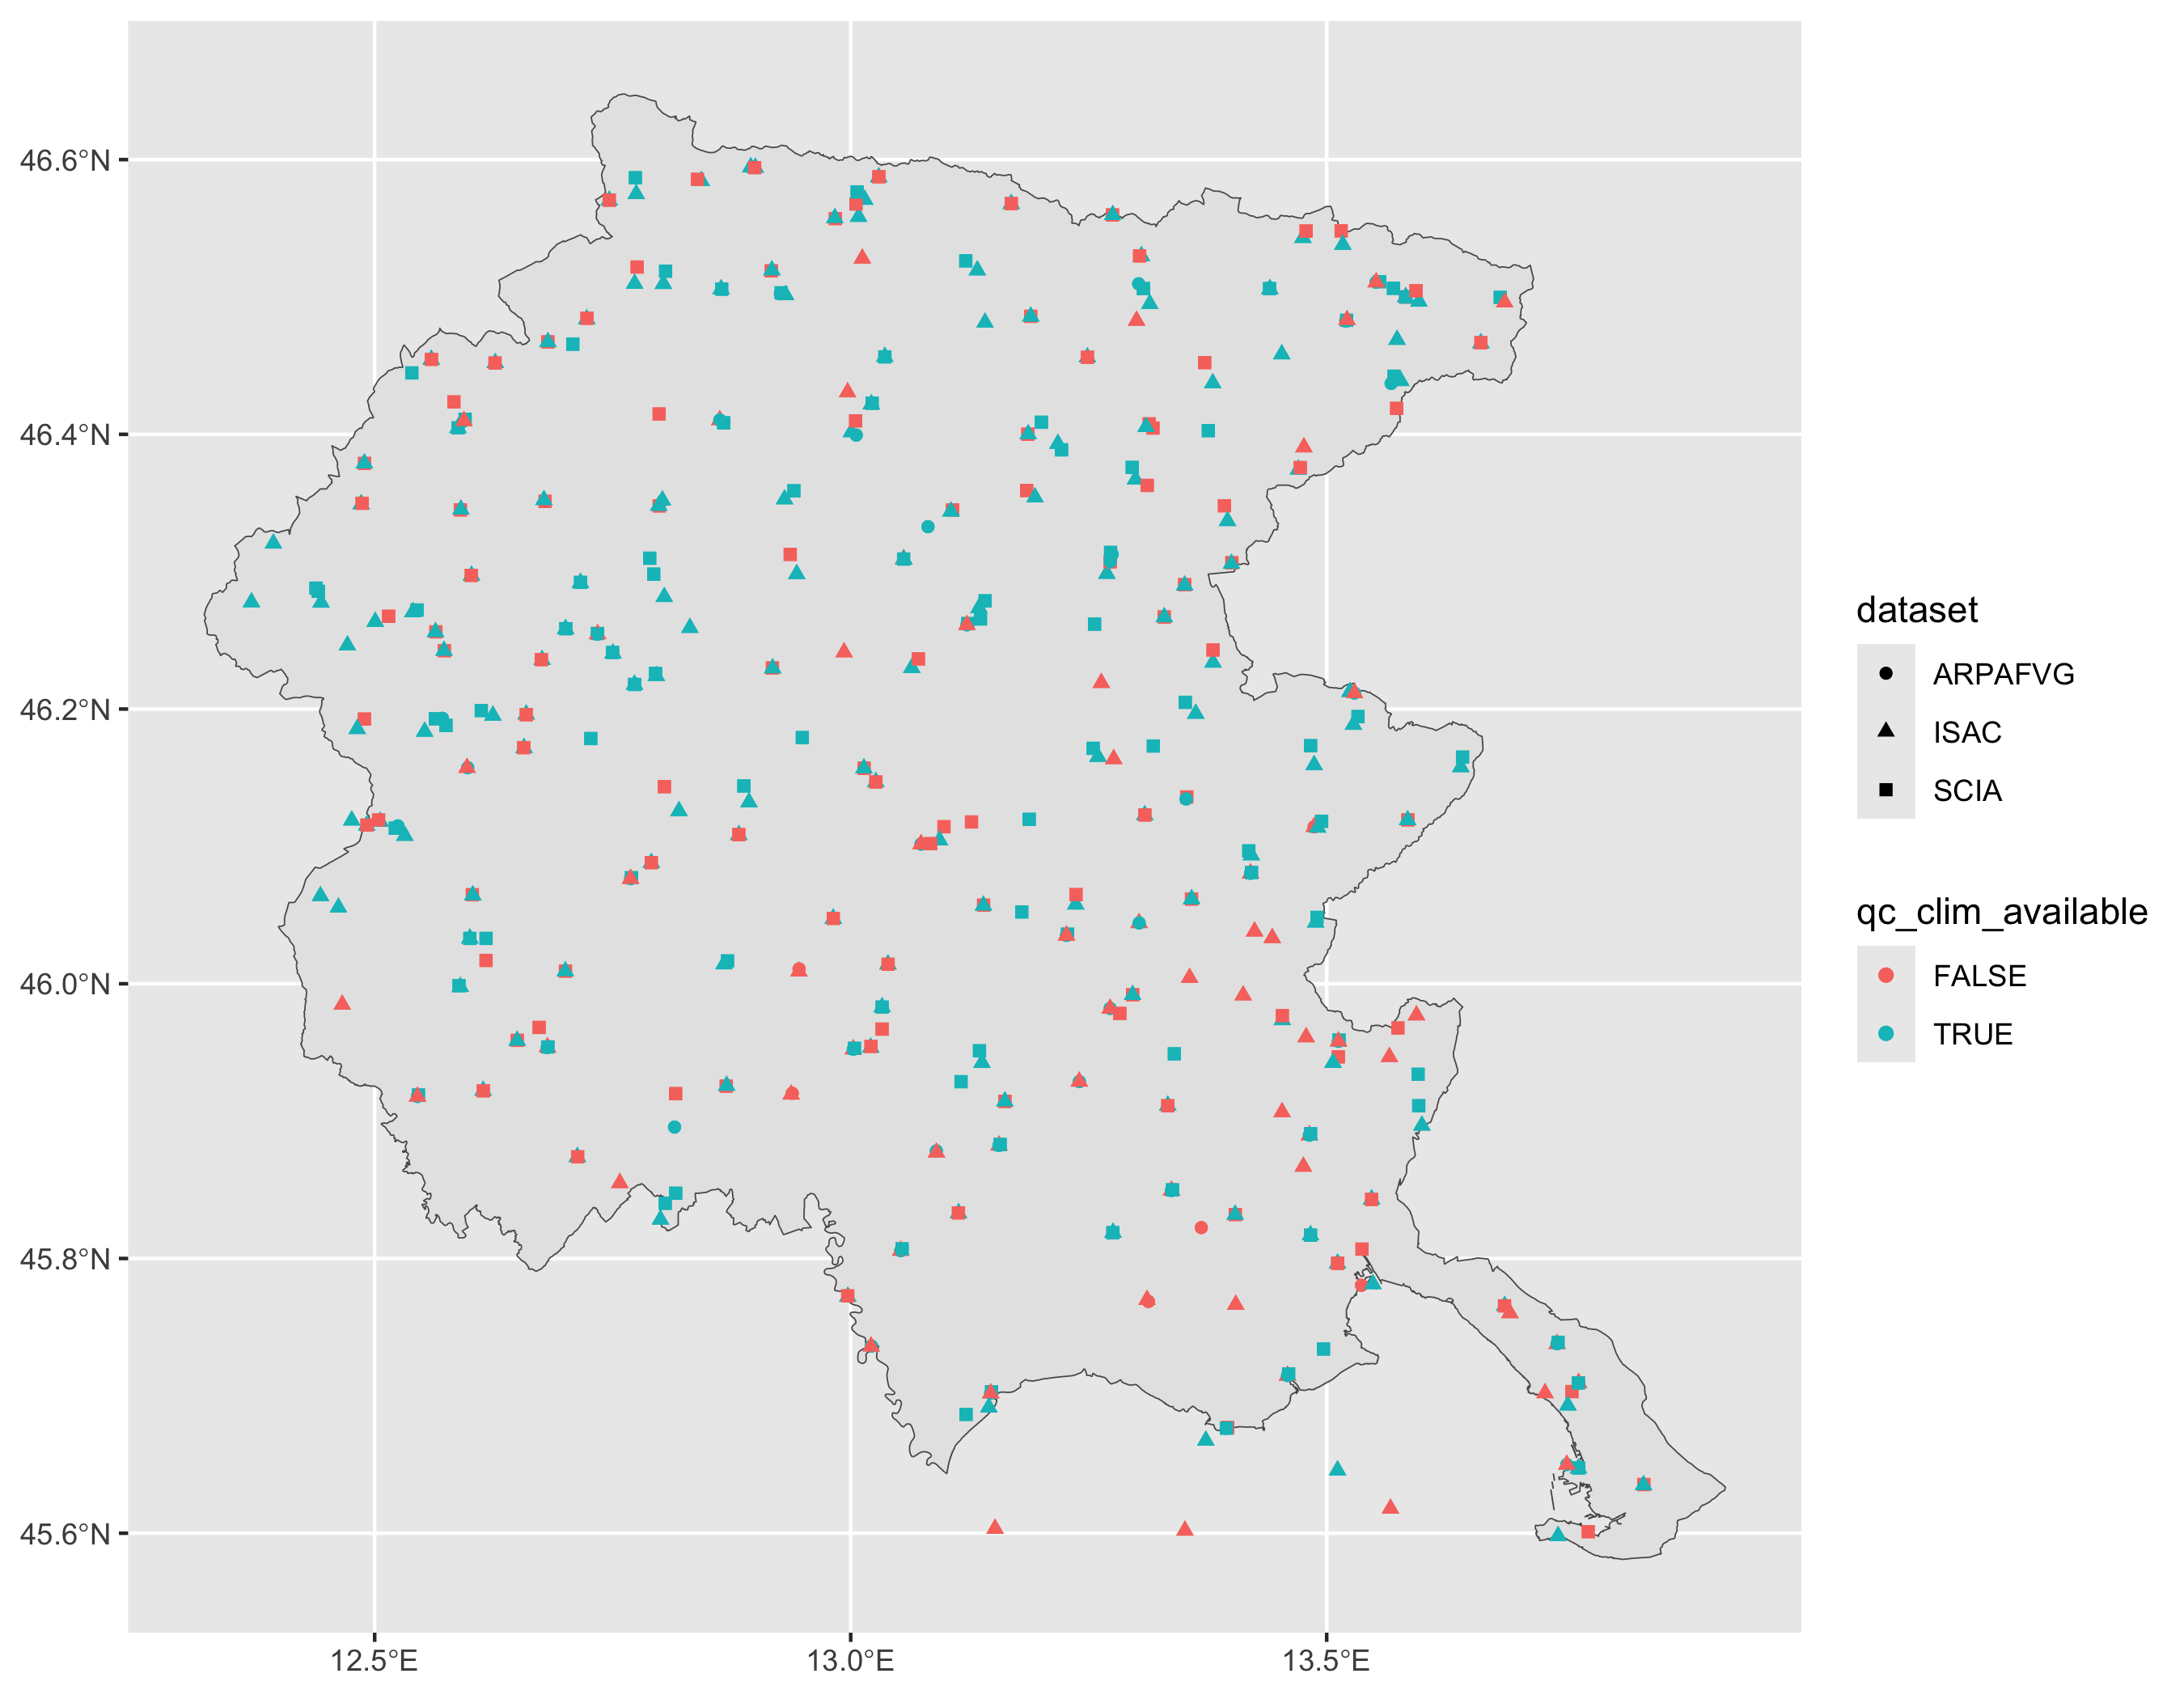

In [4]:
pp <- spatial_availabilities(pp$data, stations, state_boundaries)
pp$plot


In [8]:
pp$data |>
    group_by(dataset, qc_clim_available, variable) |>
    count()


dataset,qc_clim_available,variable,n
<chr>,<lgl>,<int>,<int>
ARPAFVG,FALSE,-1,8
ARPAFVG,FALSE,1,8
ARPAFVG,TRUE,-1,42
ARPAFVG,TRUE,1,42
ISAC,FALSE,-1,60
ISAC,FALSE,1,60
ISAC,TRUE,-1,151
ISAC,TRUE,1,151
SCIA,FALSE,-1,102
